In [1]:
from lorenz_setup import simulate_lorenz

In [2]:
import matplotlib.pyplot as plt

In [3]:
import torch
import numpy as np

In [4]:
from lorenz_settings import (
    N_UNITS,
    MAX_DELAY,
    ALPHA,
    BETA,
    GAMMA,
    DT,
    LMBDA1,
    LMBDA2,
    LMBDA3,
    LMBDA4,
    U_FACTOR,
    W_FACTOR,
)

In [5]:
def preprocess_X(X):
    # normalize features to mean 0 and variance 1 
    # return (X - X.mean(axis=0)) / np.std(X, axis=0)
    # normalize features to range [0, 1]
    return (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

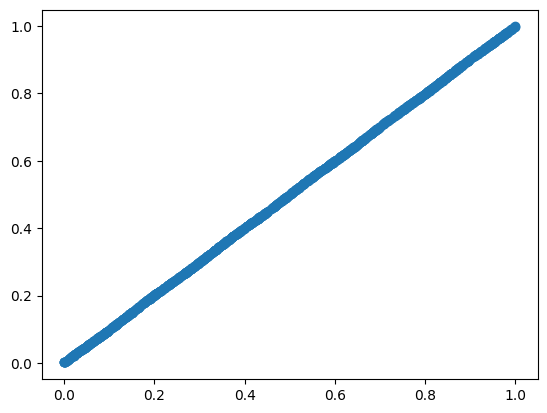

In [6]:
def generate_tuning_curves(scalars, dimensions, width):
    """
    Generate tuning curves as Gaussian curves centered around scalar values.
    
    Args:
    scalars (ndarray): Array of scalar values between 0 and 1.
    dimensions (int): Number of dimensions in the array.
    width (float): Width of the Gaussian curve.
    
    Returns:
    tuning_curves (ndarray): Array of N-dimensional arrays representing tuning curves.
    """
    positions = np.linspace(-3 * width, 1 + 3 * width, dimensions)
    tuning_curves = np.exp(-((positions[np.newaxis, :] - scalars[:, np.newaxis]) ** 2) / (2 * width ** 2))
    return tuning_curves

def estimate_scalars_from_tuning_curves(tuning_curves, width):
    """
    Estimate scalar values from arrays of N-dimensional tuning curves.
    
    Args:
    tuning_curves (ndarray): Array of N-dimensional arrays representing tuning curves.
    width (float): Width of the Gaussian curve used to generate the tuning curves.
    
    Returns:
    estimated_scalars (ndarray): Array of estimated scalar values.
    """
    dimensions = tuning_curves.shape[1]
    positions = np.linspace(-3 * width, 1 + 3 * width, dimensions)
    
    # Compute the estimated scalar values for each tuning curve
    tuning_curves = tuning_curves / tuning_curves.sum(1)[:, np.newaxis]
    estimated_scalars = np.sum(positions * tuning_curves, axis=1) / np.sum(tuning_curves, axis=1)
    return estimated_scalars


n_units_p = 10
width_of_curve = 1/n_units_p

num_samples = 1000
scalar_values = np.random.rand(num_samples)

tuning_curves = generate_tuning_curves(scalar_values, n_units_p, width_of_curve)
estimated_scalars = estimate_scalars_from_tuning_curves(tuning_curves, width_of_curve)

plt.scatter(scalar_values, estimated_scalars)

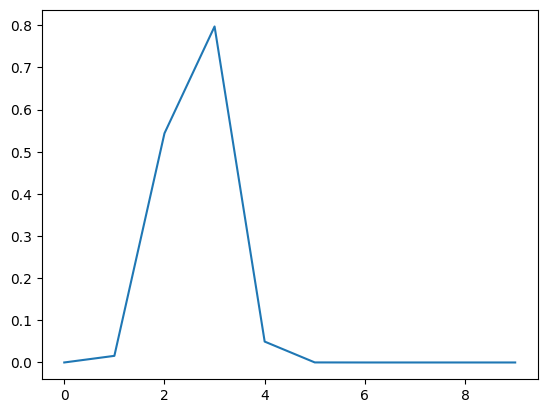

In [141]:
%matplotlib inline
plt.plot(tuning_curves[0])

In [7]:
def get_X(
    sigma=10,
    rho=28,
    beta=8 / 3,
    duration=2000,
    dt=0.01,
    initial_state=[0, 5, 0],
    n_units_p=10
):
    # Time points
    t = np.arange(0, duration, dt)
    
    # Simulate the Lorenz system
    X_raw = preprocess_X(simulate_lorenz(t, initial_state, sigma, rho, beta))

    X = np.array([
        generate_tuning_curves(X_raw[:, i], n_units_p, width_of_curve)
        for i in range(3)
    ])
    return X_raw, np.transpose(X, (1, 0, 2))

In [8]:
X_raw, X = get_X(duration=5000)

In [99]:
def nonlinearity(x, scale=3, offset=0.5):
    return 1 / (1 + torch.exp(-scale * (x - offset)))

In [10]:
def f_lateral_inhibition(mean_activity, target_activity=0.2):
    return max(mean_activity - target_activity, 0)

In [11]:
from matplotlib.animation import FuncAnimation

def animate_scatter_and_line(positions, trajectory):
    T, _, N = positions.shape
    M, _ = trajectory.shape

    # Create a figure and 3D axis for the scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter([], [], [], c='b', marker='o')
    line, = ax.plot([], [], [], c='r', linewidth=0.5, alpha=0.5)  # Static line trajectory

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)

    # Update function for animation
    def update(frame):
        x = positions[frame, 0, :]
        y = positions[frame, 1, :]
        z = positions[frame, 2, :]
        scatter._offsets3d = (x, y, z)

        line.set_data(trajectory[:, 0], trajectory[:, 1])
        line.set_3d_properties(trajectory[:, 2])

        return scatter, line

    # Create the animation
    ani = FuncAnimation(fig, update, frames=T, blit=True, interval=5)
    return fig, ani

In [318]:
def simulate(
    X,
    lmbda1 = LMBDA1,
    lmbda2 = 8,
    lmbda3 = 5e-1,
    lmbda4 = 5e-1,
    n_units = N_UNITS,
    dt = DT,
    alpha = ALPHA,
    beta_in = 1e-2,
    gamma = 1
):
    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )  # Use GPU if available
    
    n_steps, n_features, n_units_p = X.shape

    #w = 1 * np.random.randn(n_units, n_features, n_units_p)
    #w -= w.mean()
    w = np.random.uniform(0.1, 0.2, size=(n_units, n_features, n_units_p))
    
    V = torch.zeros((n_steps, n_units), device=device)
    X = torch.from_numpy(X).to(device)
    w = torch.from_numpy(w).to(device)
    a = torch.zeros(n_units, device=device)

    W = []
    W_mean_hist = []
    W_var_hist = []
    DW_max = []
    
    for t in range(n_steps):
        dv = (
                (
                    -lmbda1 * V[t - 1]
                    + nonlinearity(
                        torch.einsum('kij,ij->k', w, X[t])
                        - lmbda2 * f_lateral_inhibition(V[t - 1].mean())
                    )
                )
                * dt
                * alpha
            )
    
        dw = (
                -lmbda3 * w.sum(2)[:, :, np.newaxis]
                - lmbda4 * a[:, np.newaxis, np.newaxis]
                + torch.einsum('ij,k->kij', X[t], dv/dt)
             ) * dt * beta_in

        V[t] = V[t - 1] + dv
        w += dw
        w = torch.relu(w)
        a += (V[t] - a) * dt * gamma

        # multiplicative / competetive normalization
        # w = 0.99 * w + 0.01 * (w / w.mean((1, 2))[:, np.newaxis, np.newaxis])
        
        W_mean_hist.append(w.mean().cpu().numpy())
        W_var_hist.append(w.var().cpu().numpy())
        if t % 500 == 0:
            W.append(w.cpu().numpy())

        DW_max.append(dw.abs().max().cpu().item())
    
    return V.cpu().numpy(), w.cpu().numpy(), W_mean_hist, W_var_hist, W, a, DW_max

In [337]:
dv = V[-1] - V[-2]

In [348]:
w.sum(2).max()

3.4570169968247426

In [345]:
np.einsum('ij,k->kij', X[-1], dv/DT).max()

55.37869696337128

In [340]:
np.abs(dv).max()

0.056298494

In [357]:
8 * f_lateral_inhibition(V[-1].mean())

1.047029399871826

In [354]:
np.einsum('kij,ij->k', w, X[-1])

array([1.42722681, 0.80517586, 0.71575327, 0.72941096, 3.8305721 ,
       0.218122  , 0.11424373, 0.17861615, 2.62630858, 2.33774645,
       0.23229242, 0.50703297, 3.92044622, 0.07017449, 3.5341455 ,
       1.52713278, 0.3301192 , 3.15545407, 1.04733363, 1.55231966,
       0.86698818, 0.89086849, 0.63998103, 0.36572749, 1.02055284,
       2.47804654, 0.10799707, 4.26612562, 2.50342058, 2.88832712,
       2.42190675, 0.82150934, 0.99091722, 0.32102829, 3.91210868,
       2.51898098, 0.75932549, 0.98278618, 0.16676046, 0.55840625,
       1.18858344, 0.20469462, 1.43813431, 1.81224632, 0.17221159,
       3.01782842, 0.50286284, 1.68182736, 0.13616194, 0.78965253,
       2.17214964, 4.45728642, 0.91688186, 2.39415915, 2.63011942,
       1.08271252, 0.13917426, 3.10162586, 3.89958233, 1.3504582 ,
       0.77153521, 0.22452377, 2.53925761, 2.565678  , 3.35347366,
       2.55080893, 0.2614748 , 1.53714969, 0.44002691, 0.20017139,
       0.79935031, 1.99263468, 0.02457737, 0.18325876, 0.82204

In [336]:
torch.einsum('kij,ij->k', torch.from_numpy(w), torch.from_numpy(X)[-1])

tensor([1.4272, 0.8052, 0.7158, 0.7294, 3.8306, 0.2181, 0.1142, 0.1786, 2.6263,
        2.3377, 0.2323, 0.5070, 3.9204, 0.0702, 3.5341, 1.5271, 0.3301, 3.1555,
        1.0473, 1.5523, 0.8670, 0.8909, 0.6400, 0.3657, 1.0206, 2.4780, 0.1080,
        4.2661, 2.5034, 2.8883, 2.4219, 0.8215, 0.9909, 0.3210, 3.9121, 2.5190,
        0.7593, 0.9828, 0.1668, 0.5584, 1.1886, 0.2047, 1.4381, 1.8122, 0.1722,
        3.0178, 0.5029, 1.6818, 0.1362, 0.7897, 2.1721, 4.4573, 0.9169, 2.3942,
        2.6301, 1.0827, 0.1392, 3.1016, 3.8996, 1.3505, 0.7715, 0.2245, 2.5393,
        2.5657, 3.3535, 2.5508, 0.2615, 1.5371, 0.4400, 0.2002, 0.7994, 1.9926,
        0.0246, 0.1833, 0.8220, 0.2430, 0.0954, 3.3661, 1.0426, 0.1842, 3.3869,
        2.7141, 0.8337, 0.4473, 0.2690, 2.0200, 2.8872, 0.1011, 3.2805, 0.1065,
        0.8215, 1.4855, 1.3203, 0.0664, 0.0122, 1.2194, 4.3772, 0.5876, 0.1479,
        3.9488], dtype=torch.float64)

In [319]:
V, w, W_mean_hist, W_var_hist, W, a, DW_max = simulate(X[:100000], n_units=100)

In [320]:
n_steps, n_features, n_units_p = X.shape

unit_locations_history = np.array([
    [
        estimate_scalars_from_tuning_curves(w[:, i], width_of_curve)
        for i in range(n_features)
    ]
    for w in W
])

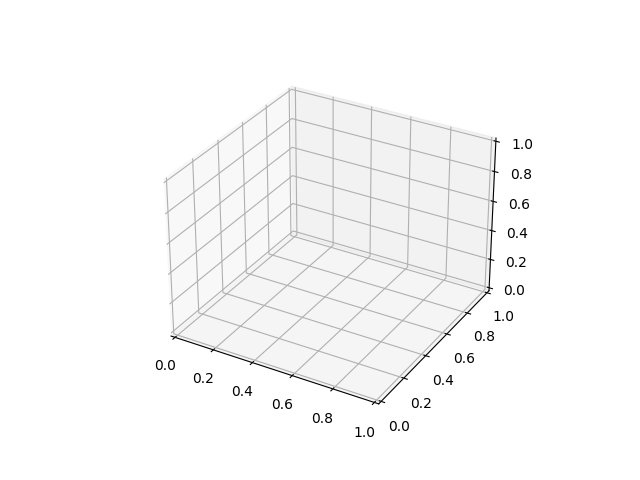

In [349]:
%matplotlib widget
fig, ani = animate_scatter_and_line(unit_locations_history, X_raw[:10000])

In [350]:
plt.close(fig)

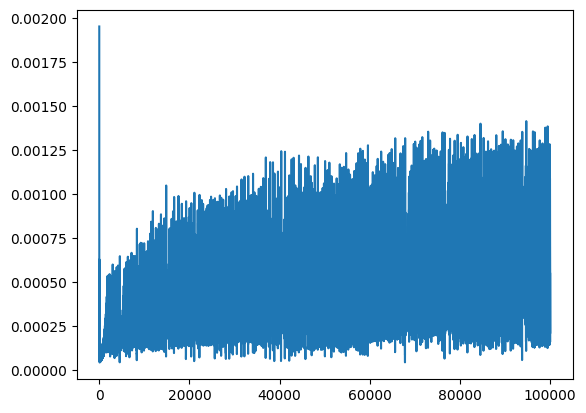

In [323]:
%matplotlib inline
plt.plot(DW_max)

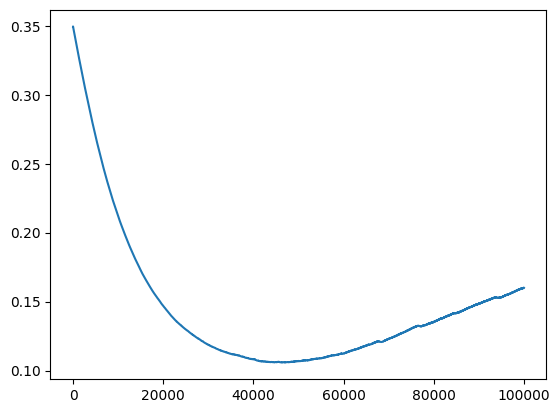

In [324]:
%matplotlib inline
plt.figure()
plt.plot(W_mean_hist)

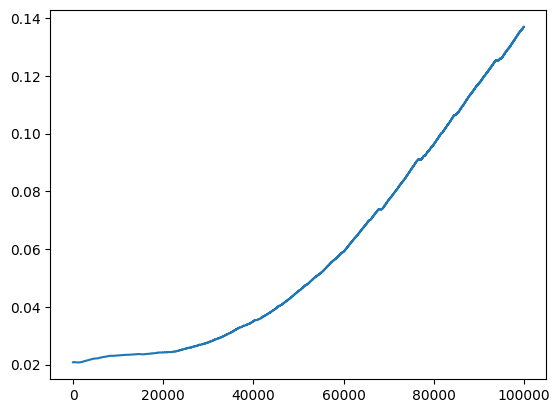

In [325]:
%matplotlib inline
plt.plot(W_var_hist)

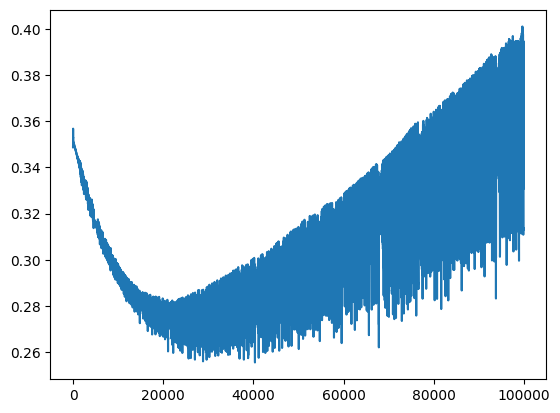

In [326]:
%matplotlib inline
plt.plot(V.mean(1)[10:])

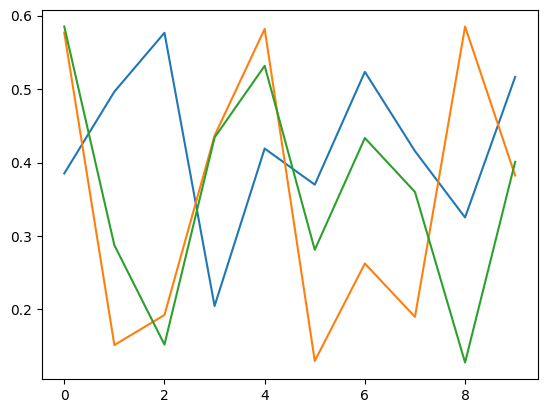

In [327]:
%matplotlib inline
plt.figure()
plt.plot(W[0][0].T)

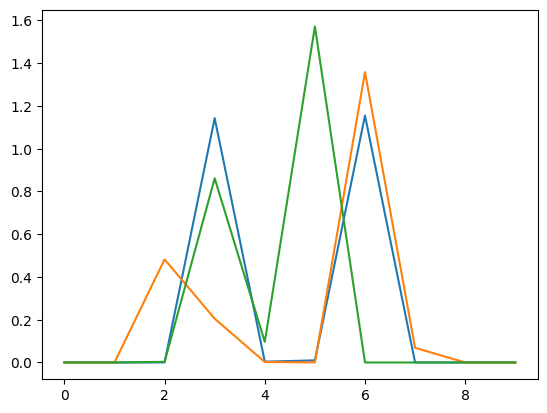

In [333]:
%matplotlib inline
plt.figure()
plt.plot(W[-1][1].T)

(array([12.,  7.,  4.,  5.,  8., 11., 15., 25.,  8.,  5.]),
 array([0.02132613, 0.04716937, 0.0730126 , 0.09885583, 0.12469907,
        0.1505423 , 0.17638553, 0.20222877, 0.228072  , 0.25391523,
        0.27975847]),
 <BarContainer object of 10 artists>)

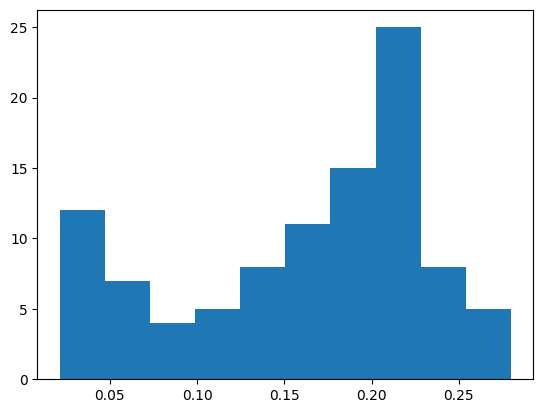

In [329]:
%matplotlib inline
plt.hist(w.mean((1,2)))

(array([19.,  8.,  9., 10., 13., 12.,  7.,  5.,  9.,  8.]),
 array([0.00709699, 0.08851911, 0.16994123, 0.25136337, 0.33278549,
        0.41420761, 0.49562973, 0.57705182, 0.65847397, 0.73989606,
        0.82131821]),
 <BarContainer object of 10 artists>)

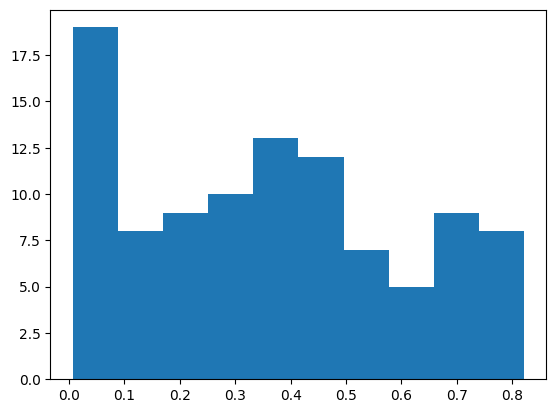

In [330]:
plt.hist(V[-1000:].mean(0))

(array([52., 12.,  7.,  5.,  3.,  2.,  1.,  2.,  2., 14.]),
 array([0.030549  , 0.12623202, 0.22191504, 0.31759805, 0.41328107,
        0.50896409, 0.60464711, 0.70033013, 0.79601315, 0.89169616,
        0.98737918]),
 <BarContainer object of 10 artists>)

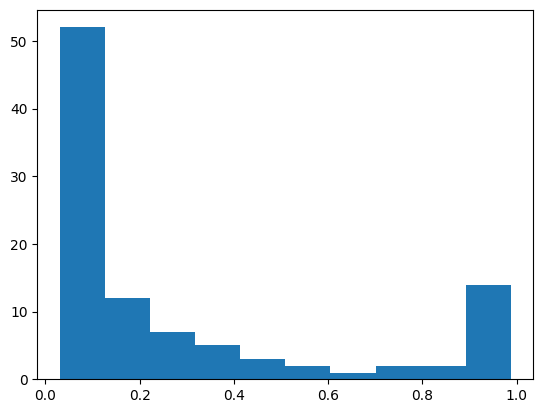

In [162]:
%matplotlib inline
plt.hist(nonlinearity(
                        torch.einsum('kij,ij->k', torch.tensor(w), torch.tensor(X[-1]))
                        - 8 * f_lateral_inhibition(V[-1 - 1].mean())
                    ))

(array([11571668.,   544452.,   357066.,   284386.,   252265.,   242220.,
          246525.,   275304.,   352339.,   873775.]),
 array([0.18242552, 0.24594042, 0.30945531, 0.37297021, 0.4364851 ,
        0.5       , 0.5635149 , 0.62702979, 0.69054469, 0.75405958,
        0.81757448]),
 <BarContainer object of 10 artists>)

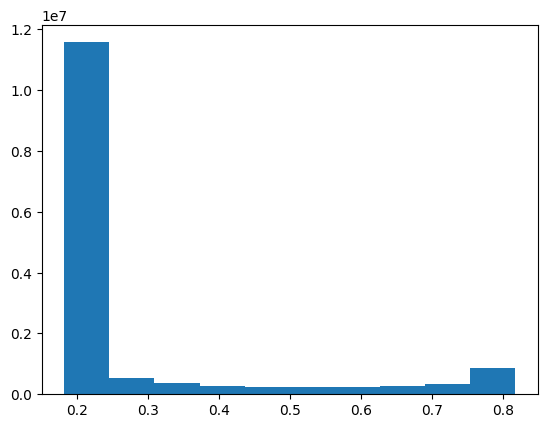

In [161]:
%matplotlib inline
plt.hist(nonlinearity(torch.tensor(X).flatten()).cpu().numpy())

In [ ]:
w.shape

In [ ]:
w_prime = w / w.sum(2)[:, :, np.newaxis]

In [ ]:
plt.plot(w[99, 2])

In [ ]:
plt.plot(w_prime[:3, 2].T)

In [ ]:
plt.plot(tuning_curves[:4].T);

In [ ]:
unit_locations_history.shape

In [241]:
unit_locations = np.array([
    estimate_scalars_from_tuning_curves(w[:, i], width_of_curve)
    for i in range(n_features)
])

In [242]:
unit_locations.max()

1.2166318837117882

In [251]:
unit_locations.shape

(3, 100)

In [243]:
unit_locations.min()

-0.2896282954398167

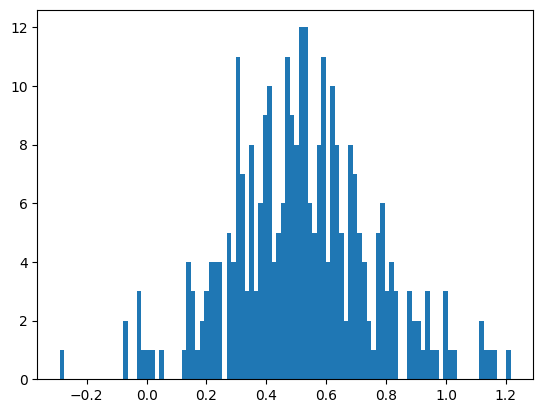

In [244]:
plt.hist(unit_locations.flatten(), bins=100);#plt.xlim(-5, 6)